In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import albumentations

import tensorflow
from keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [113]:
artists = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')
artists = artists.sort_values(by = 'paintings',ascending = False)

selected_artists = artists[0:15]
selected_artists = selected_artists[['name','genre','paintings']].reset_index()
selected_artists['class_weight'] = selected_artists.paintings.sum() / (selected_artists.shape[0] * selected_artists.paintings)
class_weights = selected_artists['class_weight'].to_dict()

new_name = 'Albrecht_Du╠êrer'
selected_artists.iloc[4,1] = new_name
selected_artists

index                   name                                    genre  \
0       8       Vincent van Gogh                       Post-Impressionism   
1      30            Edgar Degas                            Impressionism   
2      13          Pablo Picasso                                   Cubism   
3      15  Pierre-Auguste Renoir                            Impressionism   
4      19       Albrecht_Du╠êrer                     Northern Renaissance   
5      46           Paul Gauguin             Symbolism,Post-Impressionism   
6      16         Francisco Goya                              Romanticism   
7      31              Rembrandt                                  Baroque   
8      20          Alfred Sisley                            Impressionism   
9      32                 Titian               High Renaissance,Mannerism   
10     22           Marc Chagall                              Primitivism   
11      4          Rene Magritte                 Surrealism,Impressionism   
12      0      Amedeo Modigliani                            Expressionism   
13     42              Paul Klee  Expressionism,Abstractionism,Surrealism   
14     28          Henri Matisse         Impressionism,Post-Impressionism   

    paintings  class_weight  
0         877      0.384645  
1         702      0.480532  
2         439      0.768413  
3         336      1.003968  
4         328      1.028455  
5         311      1.084673  
6         291      1.159221  
7         262      1.287532  
8         259      1.302445  
9         255      1.322876  
10        239      1.411437  
11        194      1.738832  
12        193      1.747841  
13        188      1.794326  
14        186      1.813620

In [114]:
selected_artists['paintings'].sum()

5060

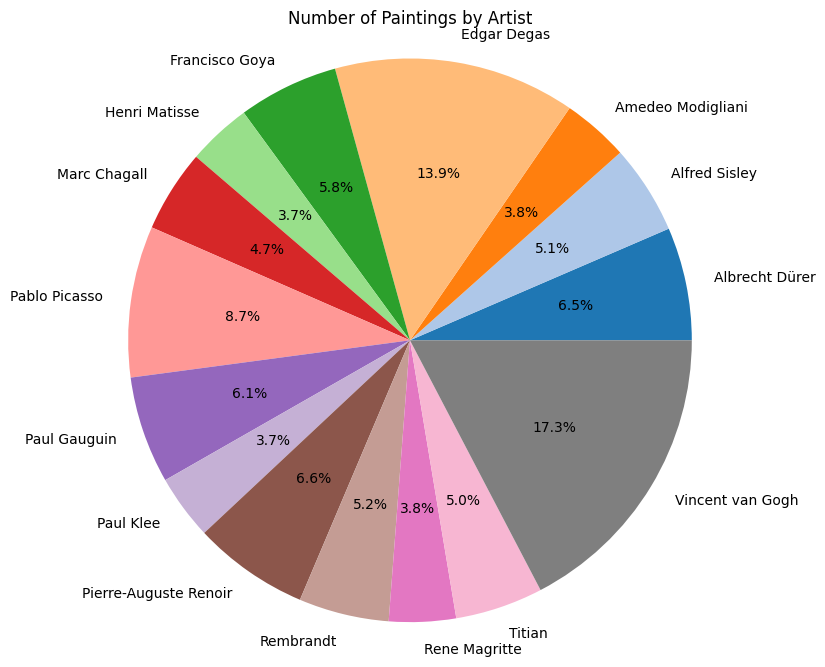

In [5]:
artist_painting_counts = selected_artists.groupby('name')['paintings'].sum()
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20(range(len(artist_painting_counts)))  # Assign colors to each artist
plt.pie(artist_painting_counts, labels=artist_painting_counts.index, autopct='%1.1f%%', colors=colors)

plt.title('Number of Paintings by Artist')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

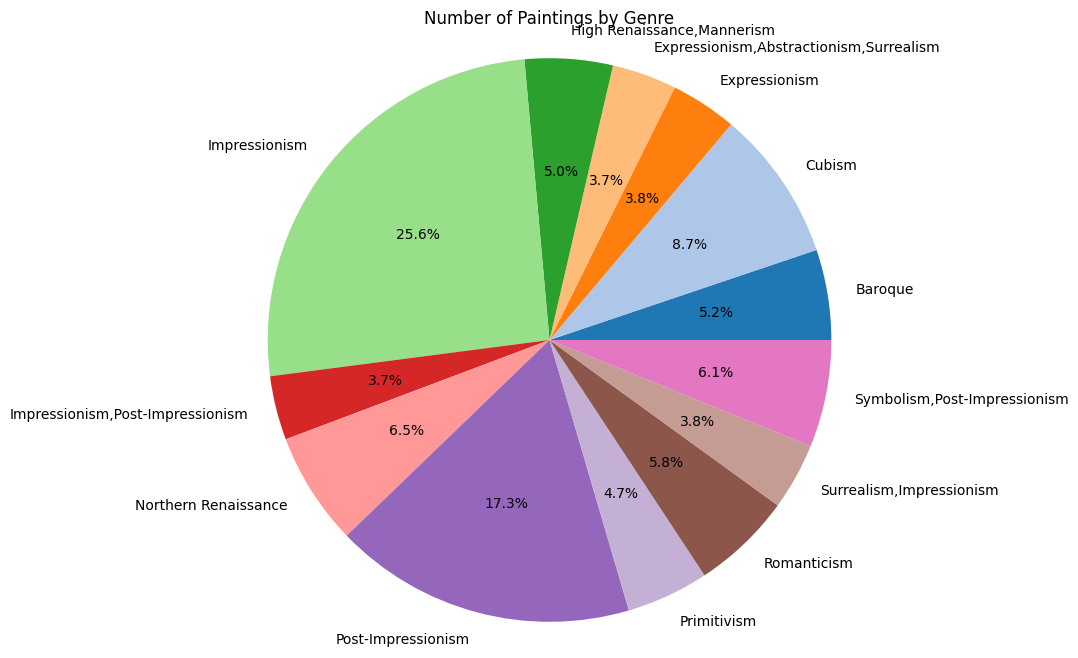

In [6]:
genre_data = selected_artists.groupby('genre')['paintings'].sum()

# Plot the pie chart
plt.figure(figsize=(8, 8))
colors = plt.cm.tab20(range(len(genre_data)))  # Assign colors to each genre
plt.pie(genre_data, labels=genre_data.index, autopct='%1.1f%%', colors=colors)

# Specify the artist names as annotations
for i, label in enumerate(genre_data.index):
    artists_for_genre = artists[artists['genre'] == label]
    artists_names = artists_for_genre['name'].unique()
    artists_text = "\n".join(artists_names)

plt.title('Number of Paintings by Genre')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [117]:
images_dir = '/kaggle/input/best-artworks-of-all-time/images/images'
artist_names = os.listdir(images_dir)

selected_artists['name'] = selected_artists['name'].str.replace(' ','_')
for name in selected_artists['name']:
    if os.path.exists(os.path.join(images_dir, name)):
        os.path.join(images_dir, name)

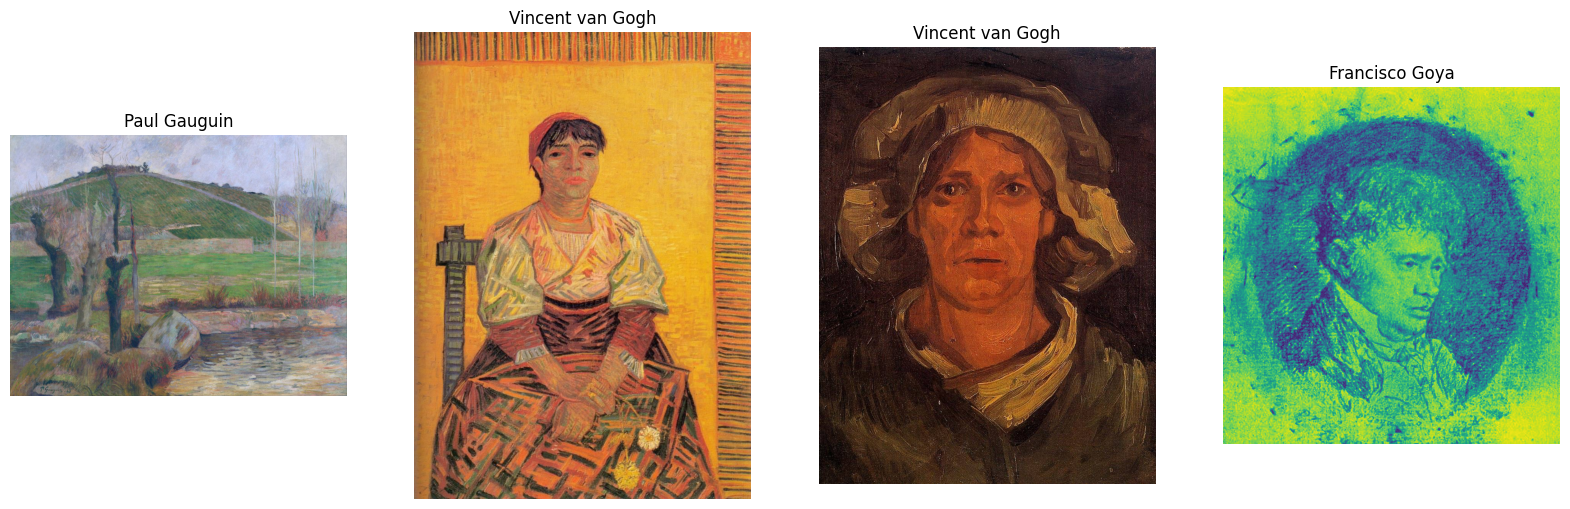

In [73]:
import random
n = 4

fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(selected_artists['name'].values)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title(random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [84]:
n_classes = selected_artists.shape[0]
batch_size = 16
image_size = (224, 224, 3)

In [118]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
#                                    width_shift_range=0.25,
#                                    height_shift_range=0.25,
                                   shear_range=5,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode = "wrap",
                                  )


train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=image_size[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=selected_artists['name'].tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=image_size[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=selected_artists['name'].tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 4055 images belonging to 15 classes.
Found 1005 images belonging to 15 classes.
Total number of batches = 253 and 62


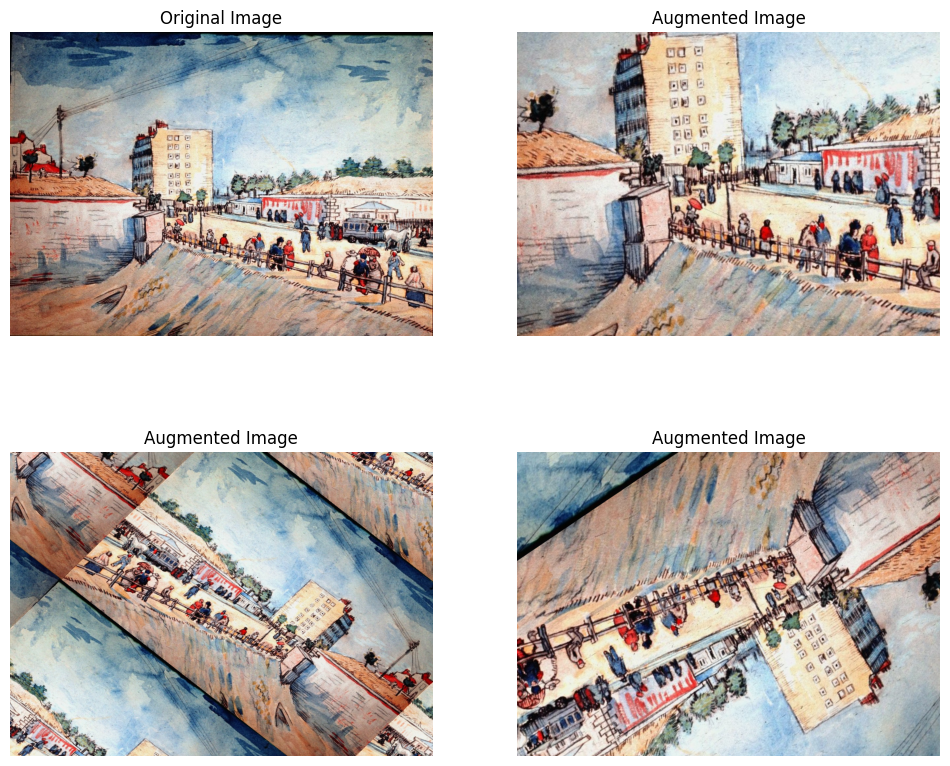

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

# Select a random artist
random_artist = random.choice(selected_artists['name'].values)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# Transformed images
for i in range(1, 4):
    row = i // 2
    col = i % 2
    aug_image = train_datagen.random_transform(image.copy())  # Apply the random transformation
    axes[row, col].imshow(aug_image)
    axes[row, col].set_title("Augmented Image")
    axes[row, col].axis('off')

plt.show()

Custom Model

In [13]:
custom_model = Sequential()
custom_model.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3)))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size = (2,2)))

custom_model.add(Conv2D(64, (3, 3)))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size = (2,2)))

custom_model.add(Conv2D(128, (3, 3)))
custom_model.add(BatchNormalization())
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size = (2,2)))

custom_model.add(Flatten())
custom_model.add(Dense(128, activation = 'relu'))
custom_model.add(Dense(32, activation = 'relu'))
custom_model.add(Dropout(0.3))

custom_model.add(Dense(n_classes, activation = 'softmax'))

custom_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

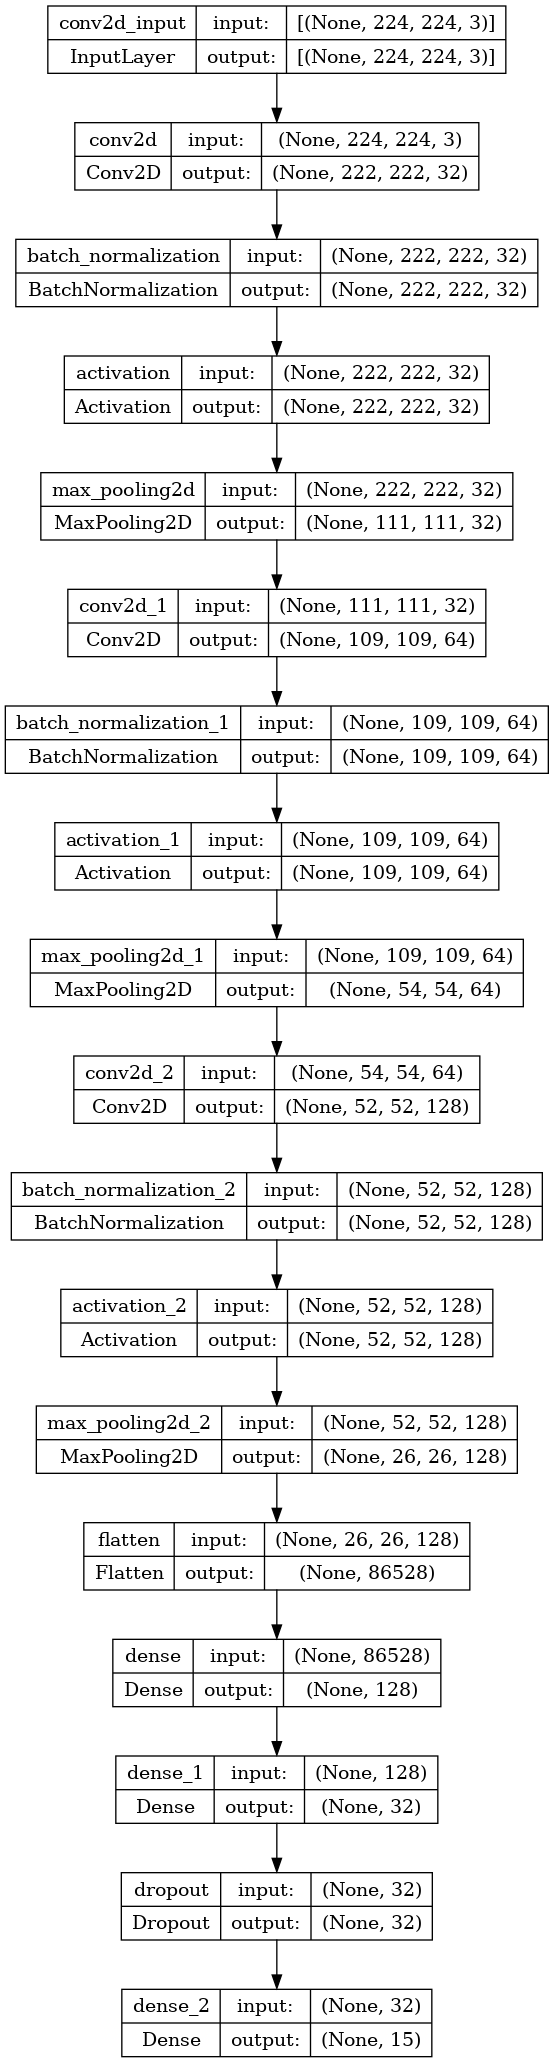

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(custom_model, show_shapes=True, show_layer_names=True)

In [15]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

In [16]:
number_of_epochs = 20
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

log_dir1 = "/kaggle/working/logs/model1"
tensorboard_callback = TensorBoard(log_dir1)
%load_ext tensorboard

In [17]:
history = custom_model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = number_of_epochs,
                    callbacks = [early_stop, tensorboard_callback]
)

Epoch 1/20
237/237 [==============================] - 124s 471ms/step - loss: 3.3108 - accuracy: 0.1799 - val_loss: 2.6516 - val_accuracy: 0.1843
Epoch 2/20
237/237 [==============================] - 82s 344ms/step - loss: 2.6295 - accuracy: 0.1851 - val_loss: 2.6082 - val_accuracy: 0.1832
Epoch 3/20
237/237 [==============================] - 82s 347ms/step - loss: 2.5922 - accuracy: 0.1851 - val_loss: 2.5746 - val_accuracy: 0.1864
Epoch 4/20
237/237 [==============================] - 82s 347ms/step - loss: 2.5659 - accuracy: 0.1851 - val_loss: 2.5531 - val_accuracy: 0.1875
Epoch 5/20
237/237 [==============================] - 82s 345ms/step - loss: 2.5477 - accuracy: 0.1851 - val_loss: 2.5411 - val_accuracy: 0.1853
Epoch 6/20
237/237 [==============================] - 82s 344ms/step - loss: 2.5353 - accuracy: 0.1851 - val_loss: 2.5281 - val_accuracy: 0.1843
Epoch 7/20
237/237 [==============================] - 83s 348ms/step - loss: 2.5275 - accuracy: 0.1846 - val_loss: 2.5214 - val_a

In [23]:
custom_history = {}
custom_history['loss'] = history.history['loss']
custom_history['acc'] = history.history['accuracy']
custom_history['val_loss'] = history.history['val_loss']
custom_history['val_acc'] = history.history['val_accuracy']

In [19]:
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()

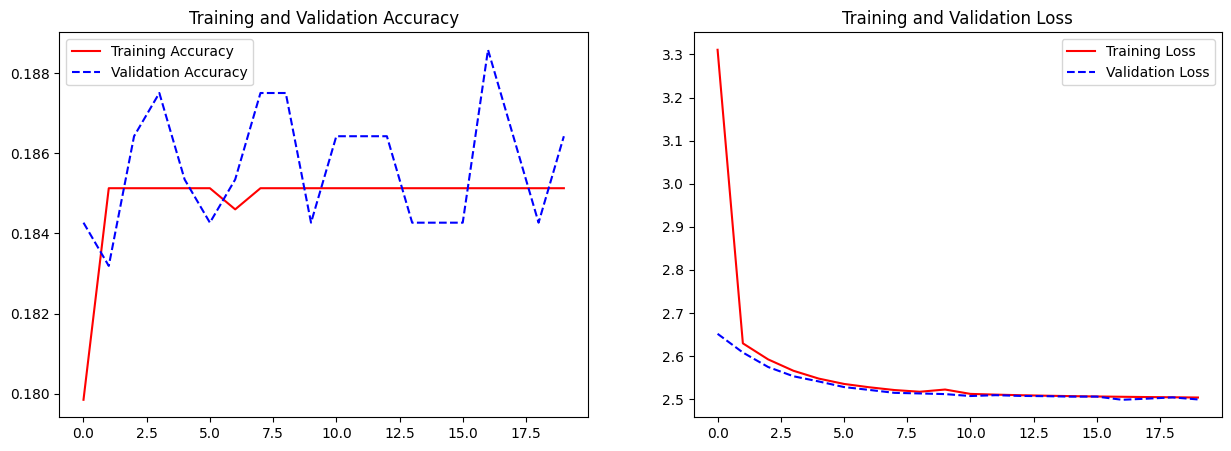

In [24]:
plot_training(custom_history)

In [25]:
custom_model.save('./custom_model.h5')

## Transfer Learning using Inception V3 (base training)

In [31]:
from keras.applications import InceptionV3
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=image_size)

for layer in Inception_model.layers:
    layer.trainable = True

In [32]:
X = Inception_model.output
X = Flatten()(X)

X = Dense(512)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(32)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation = 'softmax')(X)

Inception_model = Model(inputs = Inception_model.input, outputs = output)
Inception_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(learning_rate = 0.0002) ,metrics = ['accuracy'])

In [33]:
number_of_epochs = 30

history_Inception = Inception_model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = number_of_epochs,
                    shuffle=True, 
                    class_weight=class_weights
)

Epoch 1/30
237/237 [==============================] - 97s 378ms/step - loss: 1.9937 - accuracy: 0.3610 - val_loss: 1.9974 - val_accuracy: 0.3933
Epoch 2/30
237/237 [==============================] - 85s 357ms/step - loss: 1.4373 - accuracy: 0.5533 - val_loss: 1.7288 - val_accuracy: 0.4989
Epoch 3/30
237/237 [==============================] - 85s 360ms/step - loss: 1.2325 - accuracy: 0.6036 - val_loss: 1.5661 - val_accuracy: 0.5539
Epoch 4/30
237/237 [==============================] - 86s 364ms/step - loss: 1.1221 - accuracy: 0.6506 - val_loss: 1.3420 - val_accuracy: 0.5862
Epoch 5/30
237/237 [==============================] - 83s 350ms/step - loss: 1.0352 - accuracy: 0.6661 - val_loss: 1.3616 - val_accuracy: 0.5841
Epoch 6/30
237/237 [==============================] - 83s 351ms/step - loss: 0.9957 - accuracy: 0.6801 - val_loss: 1.2079 - val_accuracy: 0.6401
Epoch 7/30
237/237 [==============================] - 83s 349ms/step - loss: 0.9156 - accuracy: 0.6983 - val_loss: 1.5030 - val_ac

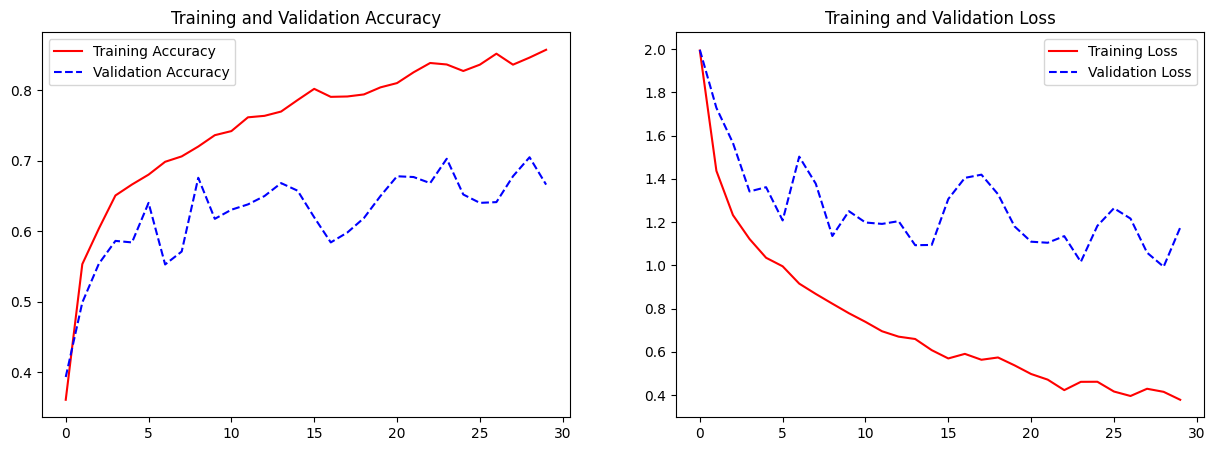

In [34]:
inception_history = {}
inception_history['loss'] = history_Inception.history['loss']
inception_history['acc'] = history_Inception.history['accuracy']
inception_history['val_loss'] = history_Inception.history['val_loss']
inception_history['val_acc'] = history_Inception.history['val_accuracy']

plot_training(inception_history)

In [35]:
results = Inception_model.evaluate(valid_generator)
results

59/59 [==============================] - 18s 297ms/step - loss: 1.1702 - accuracy: 0.6564


[1.1702035665512085, 0.6563829779624939]

## Transfer Learning using DenseNet 121 (base training)

In [119]:
from keras.applications import DenseNet121
dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=image_size)

for layer in dense_model.layers:
    layer.trainable = True

In [120]:
X = dense_model.output
X = Flatten()(X)

X = Dense(512)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(32)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation = 'softmax')(X)

dense_model = Model(inputs = dense_model.input, outputs = output)
dense_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(learning_rate = 0.0002) ,metrics = ['accuracy'])

In [121]:
number_of_epochs = 30

history_dense = dense_model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = number_of_epochs,
                    shuffle=True, 
                    class_weight=class_weights
)

Epoch 1/30
253/253 [==============================] - 115s 407ms/step - loss: 1.7629 - accuracy: 0.4516 - val_loss: 1.5329 - val_accuracy: 0.5393
Epoch 2/30
253/253 [==============================] - 92s 365ms/step - loss: 1.2555 - accuracy: 0.6410 - val_loss: 1.2687 - val_accuracy: 0.6139
Epoch 3/30
253/253 [==============================] - 93s 367ms/step - loss: 1.0412 - accuracy: 0.6984 - val_loss: 1.3401 - val_accuracy: 0.6089
Epoch 4/30
253/253 [==============================] - 93s 369ms/step - loss: 0.9485 - accuracy: 0.7074 - val_loss: 1.3403 - val_accuracy: 0.6119
Epoch 5/30
253/253 [==============================] - 92s 363ms/step - loss: 0.8117 - accuracy: 0.7569 - val_loss: 1.0632 - val_accuracy: 0.6804
Epoch 6/30
253/253 [==============================] - 93s 367ms/step - loss: 0.7505 - accuracy: 0.7606 - val_loss: 1.2651 - val_accuracy: 0.6210
Epoch 7/30
253/253 [==============================] - 92s 362ms/step - loss: 0.7020 - accuracy: 0.7717 - val_loss: 0.9941 - val_a

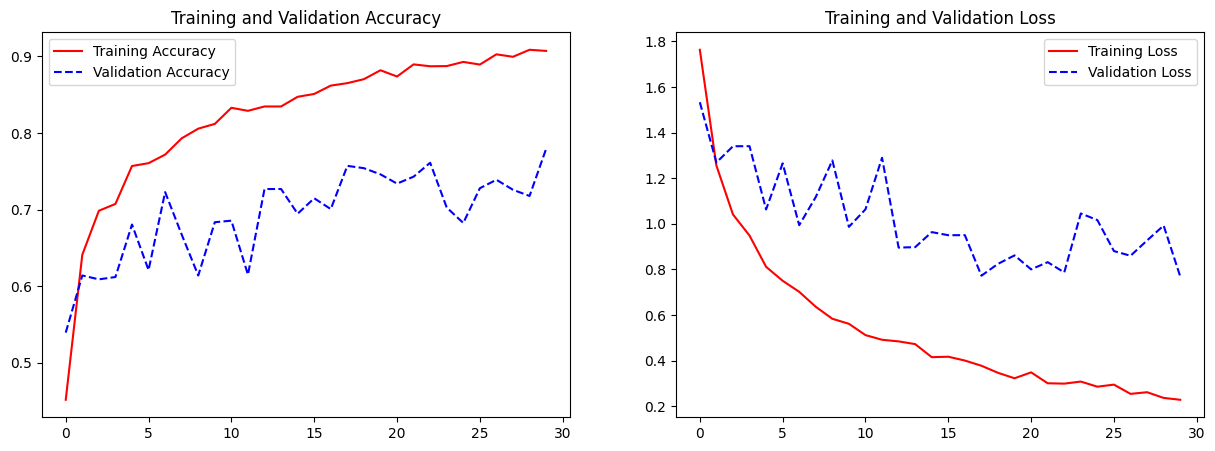

In [122]:
dense_history = {}
dense_history['loss'] = history_dense.history['loss']
dense_history['acc'] = history_dense.history['accuracy']
dense_history['val_loss'] = history_dense.history['val_loss']
dense_history['val_acc'] = history_dense.history['val_accuracy']

plot_training(dense_history)

## Further fine-tuning

In [123]:
# add a fine-tuning round, fixing the latter layers, making the earlier layers trainable
for layer in dense_model.layers:
    layer.trainable = False

for layer in dense_model.layers[:50]:
    layer.trainable = True
    
dense_model.compile(loss = 'categorical_crossentropy',optimizer = Adam(learning_rate = 0.0002) ,metrics = ['accuracy'])

In [124]:
number_of_epochs = 30

history_dense_finetune = dense_model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = number_of_epochs,
                    shuffle=True,
                    class_weight=class_weights
)

Epoch 1/30
253/253 [==============================] - 99s 362ms/step - loss: 0.0986 - accuracy: 0.9636 - val_loss: 0.6108 - val_accuracy: 0.8085
Epoch 2/30
253/253 [==============================] - 90s 357ms/step - loss: 0.0834 - accuracy: 0.9688 - val_loss: 0.6160 - val_accuracy: 0.8145
Epoch 3/30
253/253 [==============================] - 91s 359ms/step - loss: 0.0760 - accuracy: 0.9752 - val_loss: 0.6729 - val_accuracy: 0.7903
Epoch 4/30
253/253 [==============================] - 90s 357ms/step - loss: 0.0766 - accuracy: 0.9713 - val_loss: 0.5807 - val_accuracy: 0.8266
Epoch 5/30
253/253 [==============================] - 91s 358ms/step - loss: 0.0770 - accuracy: 0.9708 - val_loss: 0.6359 - val_accuracy: 0.8145
Epoch 6/30
253/253 [==============================] - 90s 357ms/step - loss: 0.0733 - accuracy: 0.9723 - val_loss: 0.5833 - val_accuracy: 0.8185
Epoch 7/30
253/253 [==============================] - 90s 357ms/step - loss: 0.0718 - accuracy: 0.9720 - val_loss: 0.6007 - val_ac

In [125]:
dense_model.save('./dense_model_finetuned.h5')

1/1 [==============================] - 0s 30ms/step


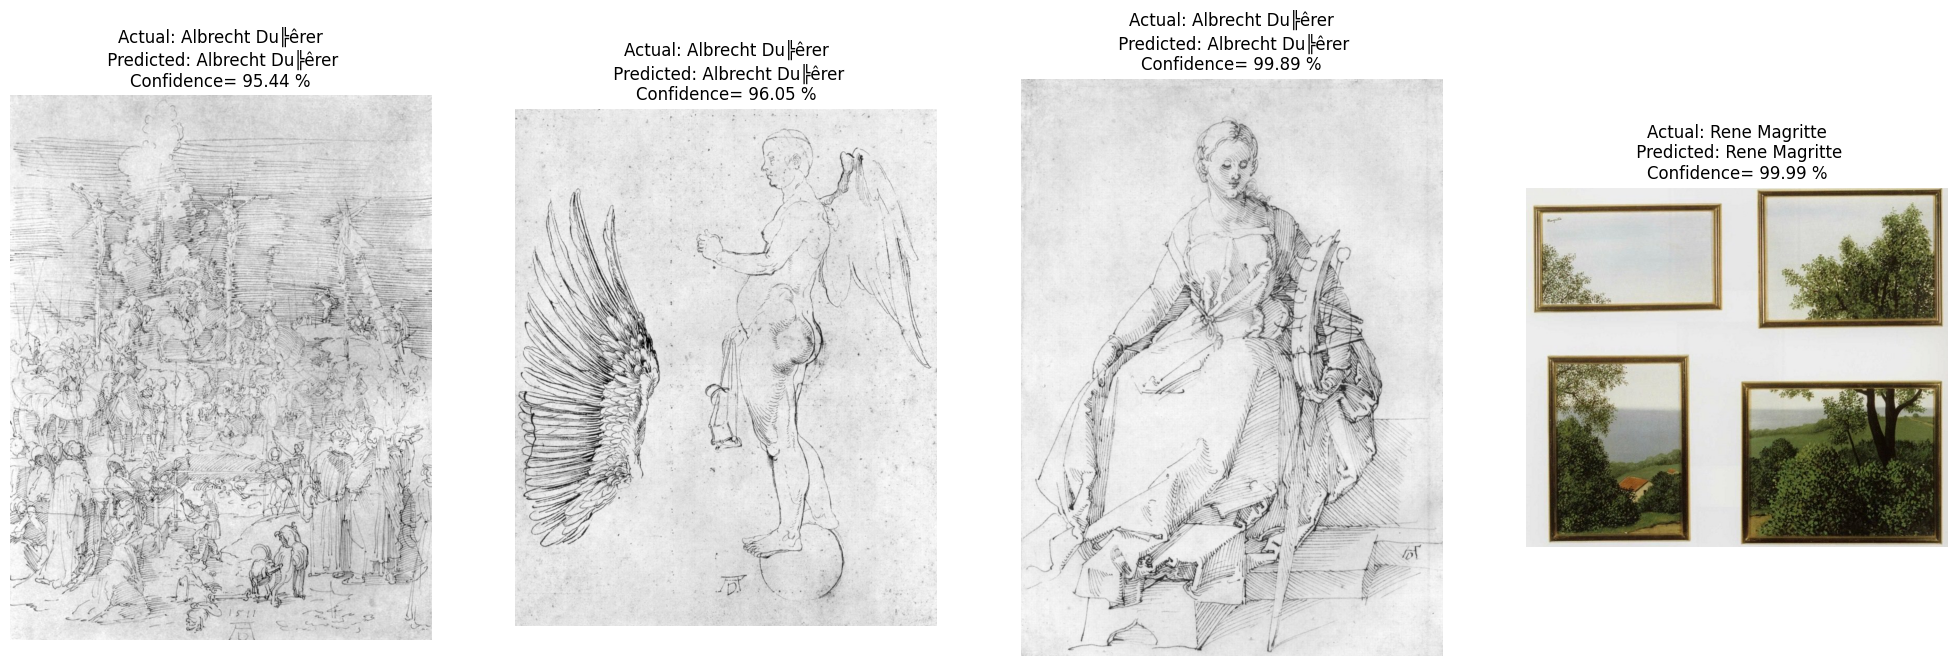

In [126]:
from keras.preprocessing import *
from keras.utils import load_img, img_to_array

n = 4
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(selected_artists['name'].values)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = load_img(random_image_file, target_size=(image_size[0:2]))

    # Predict artist
    test_image = img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = dense_model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual: {}\n Predicted: {}\nConfidence= {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

1/1 [==============================] - 0s 33ms/step


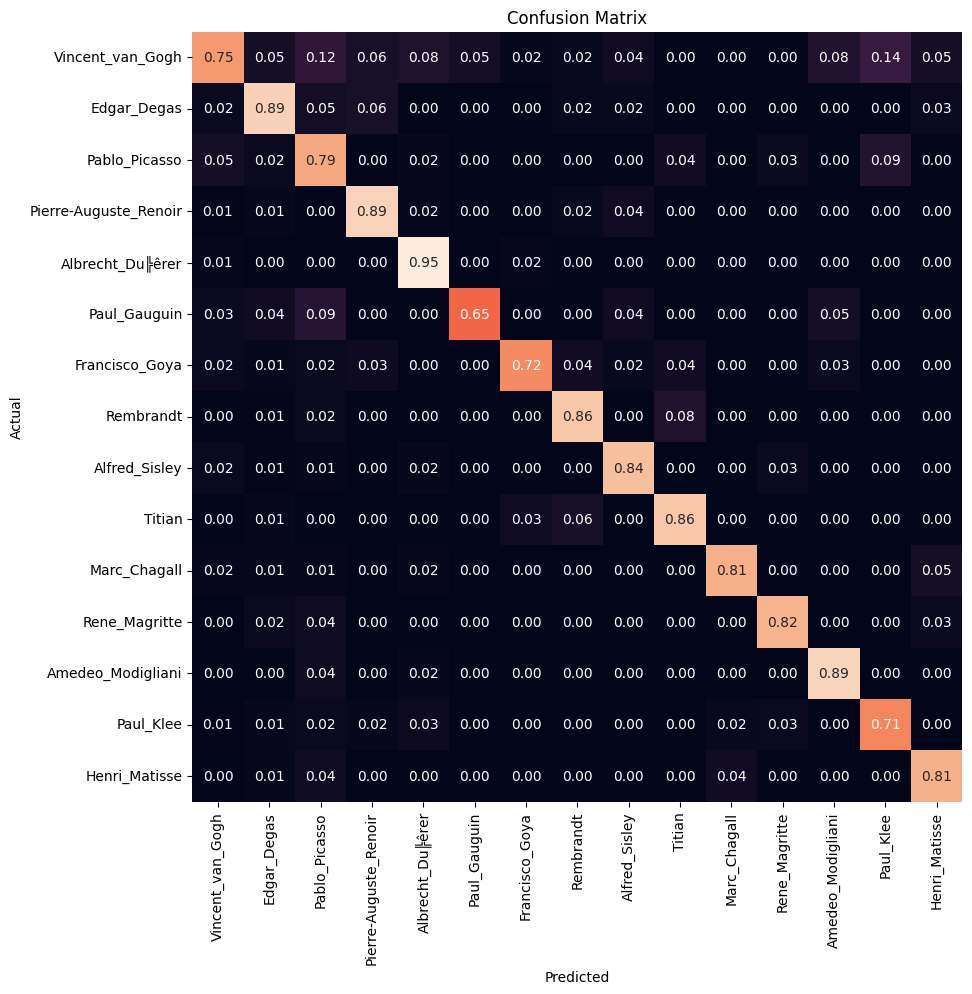

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.80      0.75      0.78       174
          Edgar_Degas       0.79      0.89      0.84       134
        Pablo_Picasso       0.63      0.79      0.70        85
Pierre-Auguste_Renoir       0.84      0.89      0.87        66
     Albrecht_Du╠êrer       0.84      0.95      0.89        65
         Paul_Gauguin       0.93      0.65      0.76        62
       Francisco_Goya       0.91      0.72      0.81        58
            Rembrandt       0.85      0.86      0.85        51
        Alfred_Sisley       0.84      0.84      0.84        51
               Titian       0.85      0.86      0.85        51
         Marc_Chagall       0.93      0.81      0.86        47
        Rene_Magritte       0.91      0.82      0.86        38
    Amedeo_Modigliani       0.85      0.89      0.87        38
            Paul_Klee       0.76      0.71      0.74        35
        Henri_Matisse       0.8

In [127]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = selected_artists['name'].values

def showClassficationReport_Generator(dense_model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(dense_model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=selected_artists['name'].values))

showClassficationReport_Generator(dense_model, valid_generator, STEP_SIZE_VALID)

In [128]:
history = {}
history['loss'] = history_dense.history['loss'] + history_dense_finetune.history['loss']
history['acc'] = history_dense.history['accuracy'] + history_dense_finetune.history['accuracy']
history['val_loss'] = history_dense.history['val_loss']+ history_dense_finetune.history['val_loss']
history['val_acc'] = history_dense.history['val_accuracy']+ history_dense_finetune.history['val_accuracy']

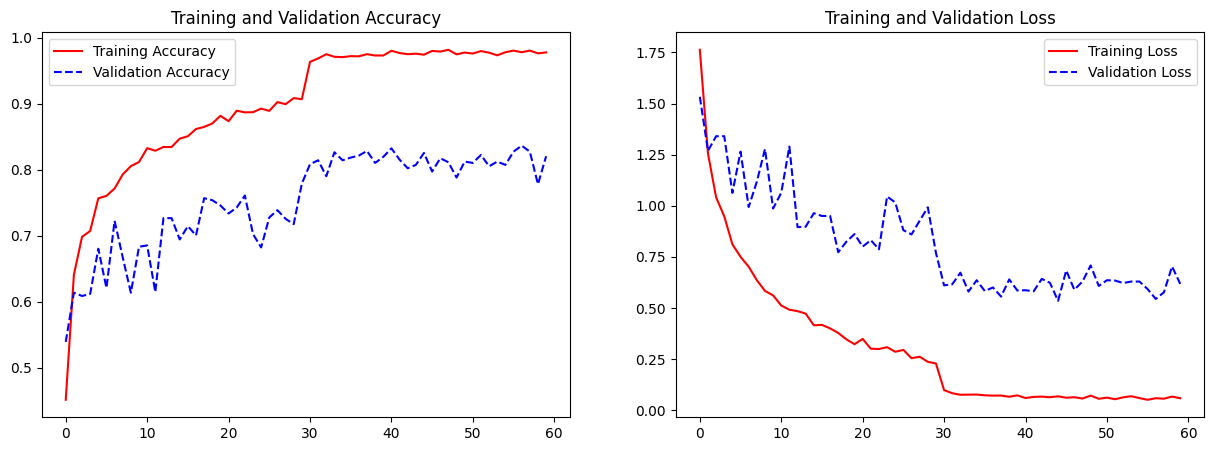

In [129]:
plot_training(history)